# PSD Analysis Delta R

## Load necessary libraries
If any of these don't load, you'll need to install them. Assuming you installed Jupyter through Anaconda, you would do the following to install a package
`conda install -c r r-[pkgName]`
e.g., to install ggplot2 you would do:
`conda install -c r r-ggplot2`

In [1]:
R.home()

[1] "/opt/conda/lib/R"

In [2]:
library(ggplot2)
library(mgcv)
library(parallel)
library(plyr)
library(tidyr)
library(data.table)
library(viridis)
# library(ggthemes)
library(nlme)

Loading required package: nlme
This is mgcv 1.8-29. For overview type 'help("mgcv-package")'.
Loading required package: viridisLite


## Load Data

In [3]:
topdir = getwd()
source(paste(topdir,'/NCIL_functions.R',sep=""))
num_cores = 4

dat = read.csv("osc_data/delta.csv")

head(dat)

X,Subj,PSD,Stim,Channel,Condition,Region,Band,Electrode_by_Subj,Stim_by_Subj,Cond_by_Subj
<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
0,1,-111.6460,standard,POz,MW1,occipital,delta,POz_1,standard_1,MW1_1
1,1,-109.4300,standard,POz,MW1,occipital,delta,POz_1,standard_1,MW1_1
2,1,-112.8012,standard,POz,MW1,occipital,delta,POz_1,standard_1,MW1_1
3,1,-114.4188,standard,POz,MW1,occipital,delta,POz_1,standard_1,MW1_1
4,1,-113.7312,standard,POz,MW1,occipital,delta,POz_1,standard_1,MW1_1
5,1,-112.0854,standard,POz,MW1,occipital,delta,POz_1,standard_1,MW1_1


In [4]:
summary(dat)

       X              Subj            PSD                Stim      
 Min.   :    0   Min.   : 1.00   Min.   :-135.81   oddball :10439  
 1st Qu.:17956   1st Qu.:12.00   1st Qu.:-118.76   standard:61386  
 Median :35912   Median :24.00   Median :-115.73                   
 Mean   :35912   Mean   :23.99   Mean   :-115.85                   
 3rd Qu.:53868   3rd Qu.:36.00   3rd Qu.:-112.86                   
 Max.   :71824   Max.   :47.00   Max.   : -95.18                   
                                                                   
    Channel      Condition         Region         Band       Electrode_by_Subj
 CPz    : 5525   MW1:22334   frontal  :27625   delta:71825   CPz_43 :  154    
 F3     : 5525   MW2:24960   occipital:22100                 F3_43  :  154    
 F4     : 5525   MW3: 3419   parietal :22100                 F4_43  :  154    
 Fp1    : 5525   MW4:15613                                   Fp1_43 :  154    
 Fp2    : 5525   MW5: 5499                                   

## Run initial full model to identify and remove outliers

Now run the model

In [5]:
m0 <- bam(PSD ~ Stim * Condition
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

In [6]:
dat <- romr.fnc(m0, dat, trim=2.5)$data

m1 <- bam(PSD ~ Stim * Condition 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

n.removed = 970 
percent.removed = 1.350505 


#### Find and remove outliers, then update model


Method: fREML   Optimizer: perf newton
full convergence after 11 iterations.
Gradient range [-4.47448e-05,4.45298e-05]
(score 206817.6 & scale 18.5533).
Hessian positive definite, eigenvalue range [0.4984577,35908.5].
Model rank =  9 / 11 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

           k'   edf k-index p-value    
s(Subj) 1.000 0.998     0.8  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


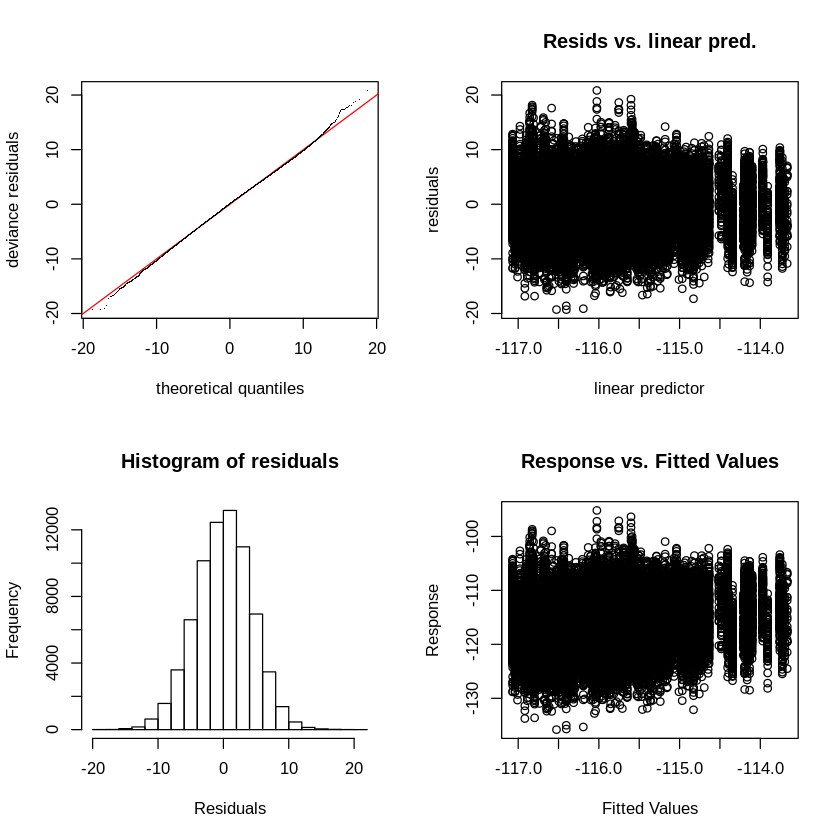

In [7]:
gam.check(m0)


Method: fREML   Optimizer: perf newton
full convergence after 11 iterations.
Gradient range [-0.0001235662,0.0001230522]
(score 200252.1 & scale 16.67892).
Hessian positive definite, eigenvalue range [0.4987584,35423.5].
Model rank =  9 / 11 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

           k'   edf k-index p-value    
s(Subj) 1.000 0.999    0.83  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


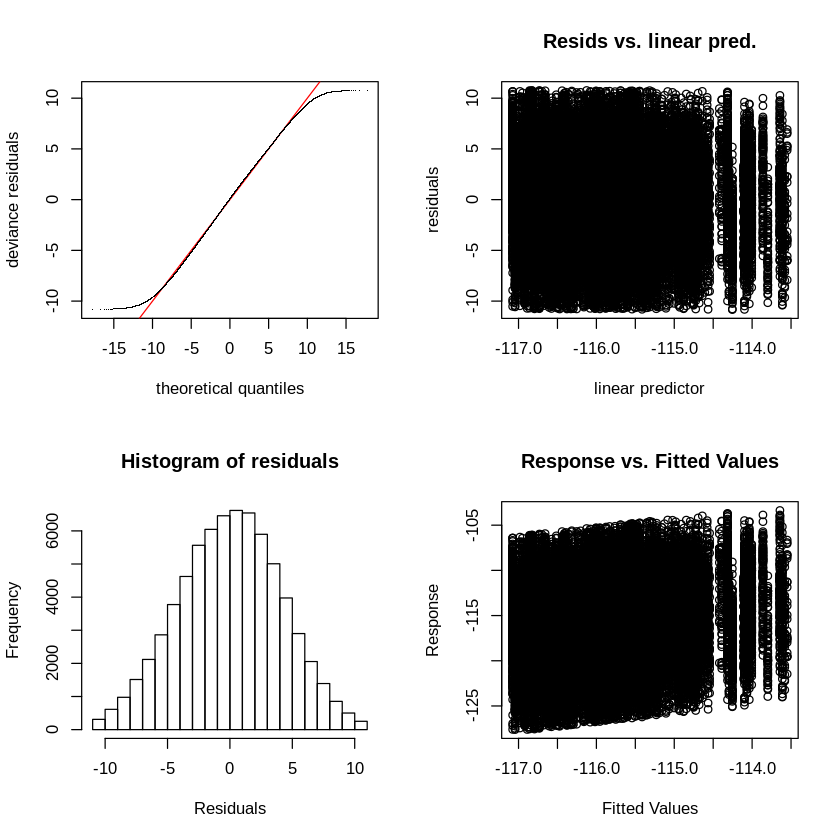

In [8]:
gam.check(m1)

## Compute LME usind data from the frontal region

In [9]:
bdat <- dat

In [10]:
dat <- bdat

In [11]:
dat <- subset(dat, Region == 'frontal') #change this as needed

# relevel data to focus on standard and MW1

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

In [12]:
summary(dat)

       X              Subj            PSD               Stim      
 Min.   :  448   Min.   : 1.00   Min.   :-127.6   standard:23243  
 1st Qu.:18280   1st Qu.:12.00   1st Qu.:-118.1   oddball : 3940  
 Median :36142   Median :24.00   Median :-115.0                   
 Mean   :36207   Mean   :24.08   Mean   :-115.2                   
 3rd Qu.:54126   3rd Qu.:36.00   3rd Qu.:-112.2                   
 Max.   :71824   Max.   :47.00   Max.   :-103.4                   
                                                                  
    Channel     Condition        Region         Band       Electrode_by_Subj
 F3     :5471   MW1:8441   frontal  :27183   delta:27183   Fp1_43 :  154    
 Fz     :5453   MW2:9433   occipital:    0                 F3_43  :  153    
 F4     :5447   MW3:1291   parietal :    0                 F4_43  :  153    
 Fp2    :5418   MW4:5918                                   Fp2_43 :  153    
 Fp1    :5394   MW5:2100                                   Fz_43  :  153    
 C

### Try many models

In [13]:
num_cores = 4

cl <- makeCluster(num_cores)

m1r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m2r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m3r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m4r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Stim_by_Subj, bs="re"), 
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m5r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m6r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m7r <- bam(PSD ~ Stim  # adding this to control for condition
           + s(Condition, bs="re")
           + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

### Select best model based on AIC

In [14]:
AICtab = as.data.frame(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r))
minAIC =  min(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r)[2]) 

AICtab$deltaAIC = lapply(AICtab$AIC, deltaAICfunc)
AICtab$deltaAIC = as.numeric(AICtab$deltaAIC)

AICtab$L= lapply(AICtab$deltaAIC, f)
AICtab$L = as.numeric(AICtab$L)

sumlike = sum(AICtab$L)

AICtab$wAIC = lapply(AICtab$L, wAICfunc)
AICtab$wAIC = as.numeric(AICtab$wAIC)

# compute relative likelihood of each model relative to model with smallest AIC/max wAIC
# So, xBetter is interpreted as "the best model is x times more likely than this model"
wAICmax = max(AICtab$wAIC)
AICtab$xBetter = lapply(AICtab$wAIC, xBetterfunc)
AICtab$xBetter = as.numeric(AICtab$xBetter)

AICtab = AICtab[order(AICtab$deltaAIC),] 
AICtab[,c('df','AIC','deltaAIC','xBetter')]

,df,AIC,deltaAIC,xBetter
,<dbl>,<dbl>,<dbl>,<dbl>
m5r,340.317867,140034.8,0.0000,1.000000e+00
m4r,279.104820,140386.9,352.1418,2.928315e+76
m1r,240.194681,140553.9,519.0914,5.239147e+112
m6r,187.625152,143343.1,3308.2961,Inf
m3r,172.691449,143461.7,3426.8942,Inf
m2r,99.824969,143737.7,3702.8922,Inf
m0,9.999998,413617.1,273582.2631,Inf


### Get summary of the best model
Main effects and interactions. 

In [15]:
mod = m5r

mod_summary = anova(mod)

mod_summary


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric Terms:
               df      F  p-value
Stim            1  0.006  0.93815
Condition       4  3.633  0.00578
Stim:Condition  2 10.771 2.11e-05

Approximate significance of smooth terms:
                          edf   Ref.df       F  p-value
s(Subj)                0.9073   1.0000   0.907  0.00102
s(Electrode_by_Subj) 223.8587 234.0000 811.625  < 2e-16
s(Cond_by_Subj)      106.0188 168.0000 146.791 2.06e-13

In [16]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric coefficients:
                           Estimate Std. Error  t value Pr(>|t|)    
(Intercept)              -1.162e+02  3.674e-01 -316.189  < 2e-16 ***
Stimoddball               7.407e-03  9.545e-02    0.078  0.93815    
ConditionMW2             -1.233e-01  1.921e-01   -0.642  0.52108    
ConditionMW3              3.621e-01  2.353e-01    1.539  0.12374    
ConditionMW4              2.971e-01  2.135e-01    1.391  0.16413    
ConditionMW5              7.849e-01  2.914e-01    2.693  0.00708 ** 
Stimoddball:ConditionMW2  0.000e+00  0.000e+00       NA       NA    
Stimoddball:ConditionMW3  0.000e+00  0.000e+00       NA       NA    
Stimoddball:ConditionMW4  1.923e-01  1.475e-01    1.304  0.19237    
Stimoddball:ConditionMW5  9.650e-01  2.079e-01    4.641 3.49e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0

### Visualize these results

In [17]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Niether MW nor OT)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),-0.12,0.192,0.36,-0.60,-0.64,0.52108,0.5211
3 (Niether MW nor OT),0.36,0.235,0.95,-0.23,1.54,0.12374,0.3712
4 (Somewhat MW),0.30,0.214,0.83,-0.24,1.39,0.16413,0.3712
5 (Completely MW),0.78,0.291,1.51,0.06,2.69,0.00708,0.0283


Saving 6.67 x 6.67 in image


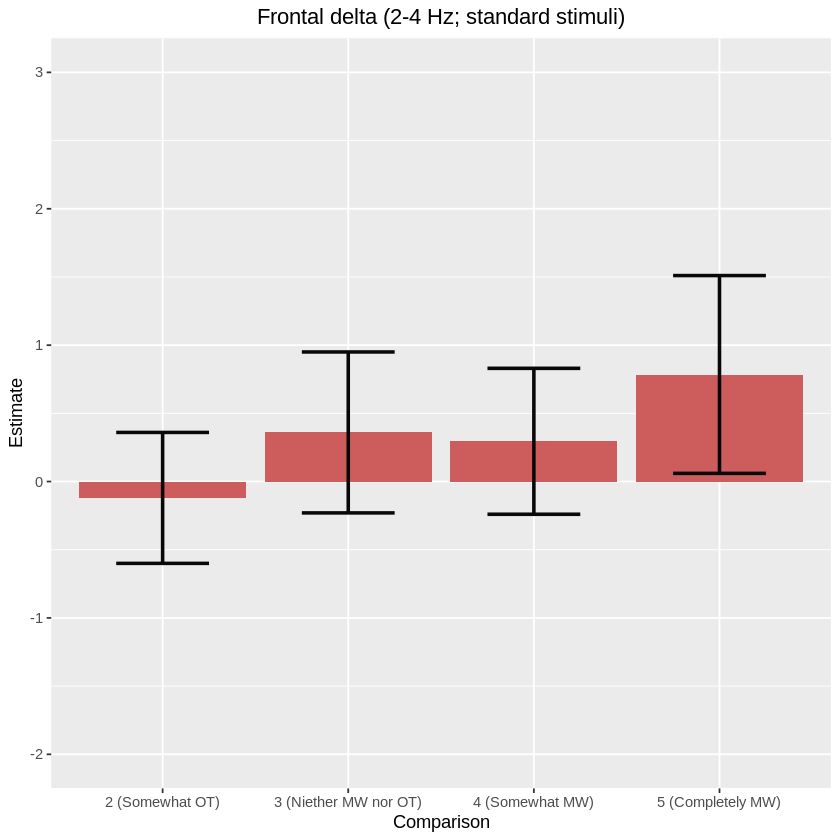

In [18]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='indianred' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-2,3) + 
        ggtitle("Frontal delta (2-4 Hz; standard stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison")

ggsave(filename='standard-delta.png', dpi=600)

### Compare MW1 oddball instead

In [19]:
# relevel data to focus on standard and MW1

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'oddball')

cl <- makeCluster(num_cores)

m7r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [20]:
mod = m7r

mod_summary = anova(mod)

mod_summary


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric Terms:
               df     F  p-value
Stim            1 0.006    0.938
Condition       3 9.018 5.77e-06
Stim:Condition  3 7.257 7.30e-05

Approximate significance of smooth terms:
                          edf   Ref.df       F  p-value
s(Subj)                0.9073   1.0000 63527.0  0.00102
s(Electrode_by_Subj) 223.8587 234.0000   763.5  < 2e-16
s(Cond_by_Subj)      106.0188 168.0000   137.6 2.72e-13

In [21]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric coefficients:
                            Estimate Std. Error  t value Pr(>|t|)    
(Intercept)               -1.162e+02  3.758e-01 -309.127  < 2e-16 ***
Stimstandard              -7.407e-03  9.545e-02   -0.078   0.9381    
ConditionMW2               0.000e+00  0.000e+00       NA       NA    
ConditionMW3               3.621e-01  2.353e-01    1.539   0.1237    
ConditionMW4               4.894e-01  2.456e-01    1.993   0.0463 *  
ConditionMW5               1.750e+00  3.383e-01    5.173 2.32e-07 ***
Stimstandard:ConditionMW2 -1.233e-01  1.921e-01   -0.642   0.5211    
Stimstandard:ConditionMW3  0.000e+00  0.000e+00       NA       NA    
Stimstandard:ConditionMW4 -1.923e-01  1.475e-01   -1.304   0.1924    
Stimstandard:ConditionMW5 -9.650e-01  2.079e-01   -4.641 3.49e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’

### Visualize the results

In [22]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Niether MW nor OT)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),0.00,0.000,0.00,0.00,NaN,NaN,NaN
3 (Niether MW nor OT),0.36,0.235,0.95,-0.23,1.54,0.12374,0.2475
4 (Somewhat MW),0.49,0.246,1.10,-0.13,1.99,0.04628,0.1388
5 (Completely MW),1.75,0.338,2.60,0.90,5.17,0.00000,0.0000


Saving 6.67 x 6.67 in image


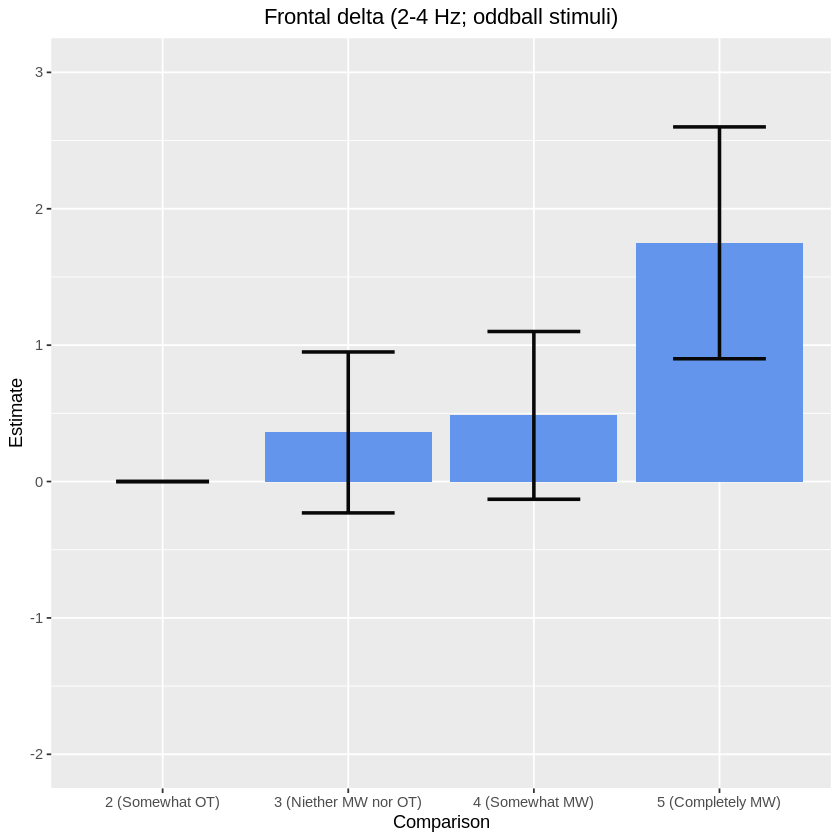

In [52]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='cornflowerblue' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ggtitle("Frontal delta (2-4 Hz; oddball stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison") + 
        ylim(-2,3)

ggsave(filename='oddball-delta.png', dpi=600)

## Compare standards and oddballs for each condition
This is in a loop to simplify the process.

In [60]:
# set up initial posthoc

dat <- subset(bdat, Region == 'frontal') #change this as needed

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

cl <- makeCluster(num_cores)

m8r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

mod = m8r

res <- t(summary(mod)$p.table[2,])
res <- as.data.frame(res)
res$Condition = paste("1 (Completely OT)")
posthocs <- res

# include the subsequent levels, looping through
mw_levels <- c('MW2','MW3','MW4','MW5')
axis_labels <- c('2 (Somewhat OT)', '3 (Neither MW nor OT)', '4 (Somewhat MW)', '5 (Completely MW)')

for(i in 1:4){
    dat[,'Condition'] <- relevel(dat[,'Condition'],mw_levels[i])
    dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

    cl <- makeCluster(num_cores)

    m8r <- bam(PSD ~ Stim * Condition  
               + s(Subj, bs="re") 
               + s(Electrode_by_Subj, bs="re")  
               + s(Cond_by_Subj, bs="re"),
              data = dat, 
              samfrac=0.1, cluster=cl, gc.level=2)

    stopCluster(cl)

    mod = m8r

    res <- t(summary(mod)$p.table[2,])
    res <- as.data.frame(res)
    res$Condition = paste(axis_labels[i])
    posthocs <- rbind(posthocs, res)
}

In [61]:
## Clean up posthocs

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1 (Completely OT),0.01,0.095,0.25,-0.24,0.08,0.93815,0.9382
2 (Somewhat OT),0.20,0.112,0.49,-0.09,1.78,0.07580,0.3032
3 (Neither MW nor OT),0.20,0.112,0.49,-0.09,1.78,0.07580,0.3032
4 (Somewhat MW),0.20,0.112,0.49,-0.09,1.78,0.07580,0.3032
5 (Completely MW),0.97,0.185,1.45,0.50,5.26,0.00000,0.0000


Saving 6.67 x 6.67 in image


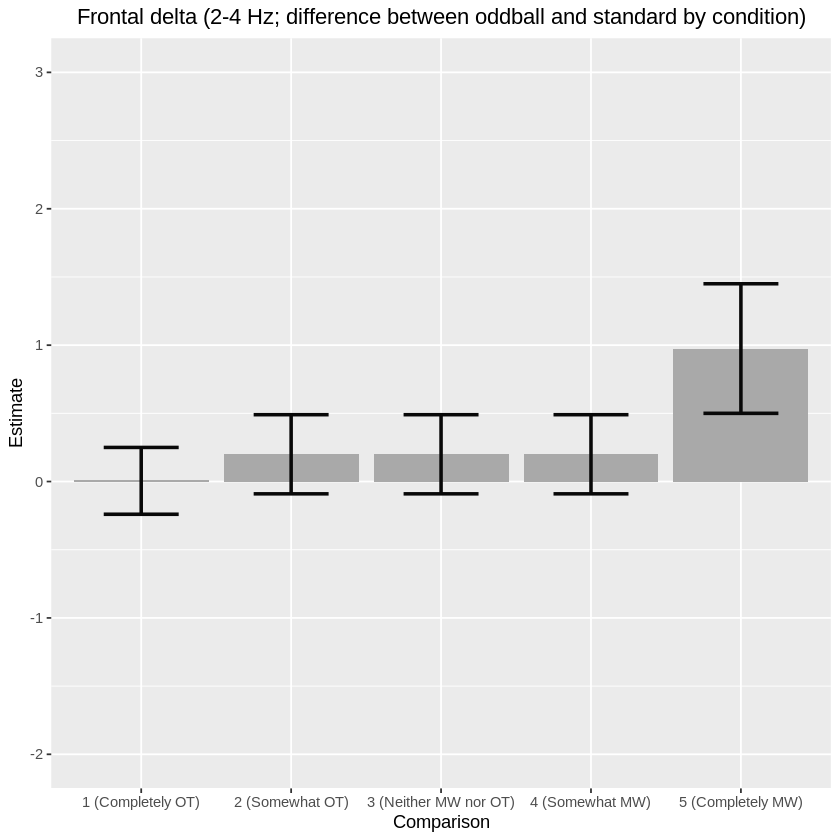

In [62]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='darkgray' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ggtitle("Frontal delta (2-4 Hz; difference between oddball and standard by condition)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison") + 
        ylim(-2,3)

ggsave(filename='oddball-difference-delta.png', dpi=600)